In [1]:
import numpy as np
import matplotlib.pyplot as plt

sample_rate = 1e6
N = 10000 # number of samples to simulate

# Create a tone to act as the transmitter signal
t = np.arange(N)/sample_rate # time vector
f_tone = 0.02e6
tx = np.exp(2j * np.pi * f_tone * t)


In [2]:
d = 0.5 # half wavelength spacing
Nr = 5
theta_degrees = 93 # direction of arrival (feel free to change this, it's arbitrary)
theta = theta_degrees / 180 * np.pi # convert to radians
a = np.exp(-2j * np.pi * d * np.arange(Nr) * np.sin(theta)) # Steering Vector
print(a) # note that it's 3 elements long, it's complex, and the first element is 1+0j

[ 1.        +0.j         -0.99999073-0.00430543j  0.99996293+0.00861078j
 -0.99991659-0.01291597j  0.99985171+0.01722092j]


In [3]:
a = a.reshape(-1,1)
print(a.shape) # 3x1
tx = tx.reshape(-1,1)
print(tx.shape) # 10000x1

# matrix multiply
r = a @ tx.T  # dont get too caught up by the transpose, the important thing is we're multiplying the Steering Vector by the tx signal
print(r.shape) # 3x10000.  r is now going to be a 2D array, 1D is time and 1D is the spatial dimension
n = np.random.randn(Nr, N) + 1j*np.random.randn(Nr, N)
r = r + 0.5*n # r and n are both 3x10000


(5, 1)
(10000, 1)
(5, 10000)


In [4]:
n

array([[-0.66495997+0.00905851j, -1.86376705-1.75894171j,
        -1.57171163-0.46167579j, ...,  0.49997799-0.40396535j,
        -0.57745896-1.43237118j,  0.78856655+0.40124516j],
       [-0.98815374+0.4515395j ,  1.23278887-0.44594215j,
        -0.94654708+0.6393949j , ...,  1.22322791-2.0187974j ,
         2.36646032+1.53033901j, -1.40923375-0.25349418j],
       [-0.03850264-1.12413916j,  0.23836019+1.57776132j,
         1.32233254-1.63831467j, ...,  0.08616354-0.46777557j,
         0.52268123-0.12600123j,  0.49174778+1.9073512j ],
       [ 0.46351987-1.8111441j , -0.7301662 -0.13896893j,
         0.55981242+0.04115986j, ...,  0.59584349-1.47864507j,
         1.10481737+1.12440638j, -0.64000842-0.91200153j],
       [-1.69053103-0.77293031j,  0.48489522-0.05779428j,
         1.39107565-1.56513261j, ..., -0.72611137+1.82301807j,
         1.15606558-0.05250425j,  1.24556734+0.07292025j]])

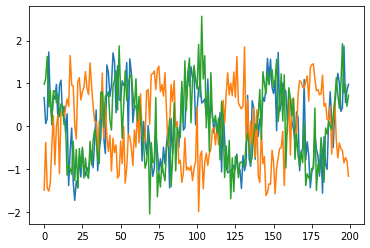

In [5]:
plt.plot(np.asarray(r[0,:]).squeeze().real[0:200]) # the asarray and squeeze are just annoyances we have to do because we came from a matrix
plt.plot(np.asarray(r[1,:]).squeeze().real[0:200])
plt.plot(np.asarray(r[2,:]).squeeze().real[0:200])
plt.show()

In [6]:
num_expected_signals = 3

In [7]:
r.shape

(5, 10000)

In [9]:
r.conj()

array([[ 0.66752002-0.00452926j,  0.06023118+0.75413762j,
         0.18272734-0.01785199j, ...,  1.17976548+0.57010723j,
         0.67985368+0.96487548j,  1.38639798-0.07528935j],
       [-1.4940676 -0.22146432j, -0.37517146+0.35257463j,
        -1.44077701-0.0668397j , ..., -0.31973885+0.64528065j,
         0.21358526-1.00968692j, -1.697262  +0.0056865j ],
       [ 0.98071161+0.5534588j ,  1.1101788 -0.92275213j,
         1.62757211+0.56213641j, ...,  0.97599362+0.59399259j,
         1.23202928+0.30334103j,  1.23903103-0.8368899j ],
       [-0.76815665+0.91848802j, -1.35549624+0.20762137j,
        -0.68538409+0.2405994j , ..., -0.63653187+0.38323766j,
        -0.41930575-0.79836214j, -1.31365496+0.34349211j],
       [ 0.15458619+0.36924423j,  1.23225683-0.11350264j,
         1.65969469+0.5172334j , ...,  0.57292237-0.55945068j,
         1.55075499+0.25822524j,  1.61690961+0.07176939j]])

In [10]:
r

array([[ 0.66752002+0.00452926j,  0.06023118-0.75413762j,
         0.18272734+0.01785199j, ...,  1.17976548-0.57010723j,
         0.67985368-0.96487548j,  1.38639798+0.07528935j],
       [-1.4940676 +0.22146432j, -0.37517146-0.35257463j,
        -1.44077701+0.0668397j , ..., -0.31973885-0.64528065j,
         0.21358526+1.00968692j, -1.697262  -0.0056865j ],
       [ 0.98071161-0.5534588j ,  1.1101788 +0.92275213j,
         1.62757211-0.56213641j, ...,  0.97599362-0.59399259j,
         1.23202928-0.30334103j,  1.23903103+0.8368899j ],
       [-0.76815665-0.91848802j, -1.35549624-0.20762137j,
        -0.68538409-0.2405994j , ..., -0.63653187-0.38323766j,
        -0.41930575+0.79836214j, -1.31365496-0.34349211j],
       [ 0.15458619-0.36924423j,  1.23225683+0.11350264j,
         1.65969469-0.5172334j , ...,  0.57292237+0.55945068j,
         1.55075499-0.25822524j,  1.61690961-0.07176939j]])

In [8]:
R = r @ r.conj().T
R

array([[ 14877.84724545  +0.j        ,  -9910.45561606 -39.91441158j,
          9923.19166337  +0.86381464j,  -9904.43554584+123.52005744j,
         10043.5681975 -209.94842208j],
       [ -9910.45561606 +39.91441158j,  14940.13612152  +0.j        ,
         -9961.36804275 +23.40816248j,   9954.61798443-267.44185489j,
         -9994.94360753+199.79250355j],
       [  9923.19166337  -0.86381464j,  -9961.36804275 -23.40816248j,
         14967.09505396  +0.j        , -10009.67199474+137.78133994j,
         10058.27518445-152.45639429j],
       [ -9904.43554584-123.52005744j,   9954.61798443+267.44185489j,
        -10009.67199474-137.78133994j,  14966.90897014  +0.j        ,
        -10069.02042403 +29.94153886j],
       [ 10043.5681975 +209.94842208j,  -9994.94360753-199.79250355j,
         10058.27518445+152.45639429j, -10069.02042403 -29.94153886j,
         15094.52851105  +0.j        ]])

In [17]:
w, v = np.linalg.eig(R) # eigenvalue decomposition, v[:,i] is the eigenvector corresponding to the eigenvalue w[i]
w.shape, v.shape

((5,), (5, 5))

In [18]:
eig_val_order = np.argsort(np.abs(w)) # find order of magnitude of eigenvalues
eig_val_order

array([2, 3, 4, 1, 0])

In [19]:
v = v[:, eig_val_order] # sort eigenvectors using this order
v

array([[-0.50858398+0.00562109j,  0.54513796+0.00501342j,
         0.16711171-0.18319158j, -0.37753403-0.20435203j,
         0.44530871-0.00576137j],
       [ 0.18369259+0.27711648j,  0.24395523+0.11774453j,
         0.76893268+0.j        , -0.1264814 +0.09045037j,
        -0.44793602+0.00161495j],
       [ 0.63688629+0.j        ,  0.46788287+0.09304707j,
        -0.07755457+0.31594108j,  0.02849529+0.24314164j,
         0.44837528+0.j        ],
       [-0.20106171+0.10769073j,  0.61505745+0.j        ,
        -0.35962722+0.04005187j,  0.48568263-0.05665196j,
        -0.44679401-0.00483586j],
       [-0.15259064+0.38709569j, -0.15338082+0.0052968j ,
         0.32094672-0.08649215j,  0.70178529+0.j        ,
         0.44755817+0.00454923j]])

In [20]:
# We make a new eigenvector matrix representing the "noise subspace", it's just the rest of the eigenvalues
V = np.zeros((Nr, Nr - num_expected_signals), dtype=np.complex64)
V.shape

(5, 2)

In [21]:
for i in range(Nr - num_expected_signals):
   V[:, i] = v[:, i]
V[:,0].shape

(5,)

In [22]:
theta_scan = np.linspace(-1*np.pi, np.pi, 1000) # -180 to +180 degrees
theta_scan.shape

(1000,)

In [35]:
results = []
arrival_angle = theta_scan[0]
max_power = -9999
angles = []
test = 0
for theta_i in theta_scan:
    a = np.exp(-2j * np.pi * d * np.arange(Nr) * np.sin(theta_i)) # Steering Vector
    a = a.reshape(-1,1)
    metric = 1 / (a.conj().T @ V @ V.conj().T @ a) # The main MUSIC equation
    print(metric)
    test = metric
    metric = np.abs(metric.squeeze()) # take magnitude
    metric = 10*np.log10(metric) # convert to dB
    if metric > max_power:
        max_power = metric
        arrival_angle = theta_i
        angles.append(theta_i)
        #print(metric, arrival_angle)
    results.append(metric)
    break



[[0.27709029-4.26209216e-18j]]


In [24]:
results /= np.max(results) # normalize

In [28]:
results[0]

-0.101912851914051

In [26]:
angles[-2] * 180 / np.pi

85.58558558558556

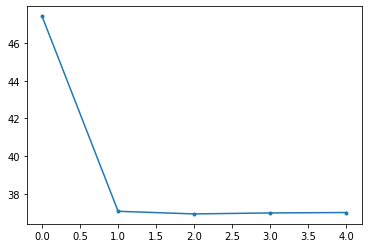

In [27]:
plt.plot(10*np.log10(np.abs(w)),'.-')